In [1]:
import numpy as np
import uproot
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import Normalize
import scipy.stats as ss
from scipy.optimize import curve_fit
from scipy.stats import norm
from ntuple_lib import *
beautify_plots(plt)
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
import matplotlib as mpl
plt.rcParams["figure.figsize"] = (12, 8)

In [2]:
def computeLocalPUDensity(all_events_vertex_zs, delta_z):
    localPUdensity = []
    for vertex_zs in all_events_vertex_zs:
        localPUdensity.append((np.sum(np.abs(vertex_zs[0]-vertex_zs[1:]) < delta_z))/(2*delta_z))
    return localPUdensity
def computeAvgPUDensity(all_events_vertex_zs, mu=200, sigma_z=50):
    avgPUdensity = []
    for vertex_zs in all_events_vertex_zs:
        avgPUdensity.append(mu/(sigma_z*np.sqrt(2*np.pi)) * np.exp(-0.5*vertex_zs[0]**2/sigma_z**2))
    return avgPUdensity

In [3]:
# files = ['ntuples_condor/OutDir_{}/hist-Rel21sample.root'.format(i) for i in range(1, 10)]
files = ['../ntuples/ttbar/hist-Rel21sample.root']
track_t = np.array([], dtype='object')
track_z0 = np.array([], dtype='object')
track_z = np.array([], dtype='object')
track_t30 = np.array([], dtype='object')
track_t90 = np.array([], dtype='object')
track_t180 = np.array([], dtype='object')

reco_vertex_track_idxs = np.array([], dtype='object')
reco_vertex_track_weights = np.array([], dtype='object')
# truth_vertex_track_idxs = np.array([], dtype='object')

reco_vertex_sumPt2 = np.array([], dtype='object')

reco_vertex_z = np.array([], dtype='object')
truth_vertex_z = np.array([], dtype='object')
truth_vertex_t = np.array([], dtype='object')

for file in files:
    root_file = uproot.open(file)
    for key in root_file.keys():
        if key.startswith('EventTree'):
            tree = root_file[key]
            track_t = np.concatenate((track_t, tree['track_t'].array(library='np')))
            track_z0 = np.concatenate((track_z0, tree['track_z0'].array(library='np')))
            track_z = np.concatenate((track_z, tree['track_z'].array(library='np')))
            track_t30 = np.concatenate((track_t30, tree['track_t30'].array(library='np')))
            track_t90 = np.concatenate((track_t90, tree['track_t90'].array(library='np')))
            track_t180 = np.concatenate((track_t180, tree['track_t180'].array(library='np')))
            
            reco_vertex_track_idxs = np.concatenate((reco_vertex_track_idxs, tree['recovertex_tracks_idx'].array(library='np')))
            reco_vertex_track_weights = np.concatenate((reco_vertex_track_weights, tree['recovertex_tracks_weight'].array(library='np')))
            # truth_vertex_track_idxs = np.concatenate((truth_vertex_track_idxs, tree['truthvertex_tracks_idx'].array(library='np')))
            
            reco_vertex_sumPt2 = np.concatenate((reco_vertex_sumPt2, tree['recovertex_sumPt2'].array(library='np')))
            
            reco_vertex_z = np.concatenate((reco_vertex_z, tree['recovertex_z'].array(library='np')))
            truth_vertex_z = np.concatenate((truth_vertex_z, tree['truthvertex_z'].array(library='np')))
            truth_vertex_t = np.concatenate((truth_vertex_t, tree['truthvertex_t'].array(library='np')))

In [4]:
reco_vertex_track_weights_flat = np.concatenate(np.concatenate(reco_vertex_track_weights))
reco_vertex_HS_track_weights_flat = np.array([])
reco_vertex_HS_n_tracks_flat = []
for event_weights in reco_vertex_track_weights:
    reco_vertex_HS_track_weights_flat = np.concatenate((reco_vertex_HS_track_weights_flat, event_weights[0]))
    reco_vertex_HS_n_tracks_flat.append(len(event_weights[0]))

<__array_function__ internals>:180: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


findfont: Font family ['Helvetica', 'Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Helvetica', 'Arial'] not found. Falling back to DejaVu Sans.


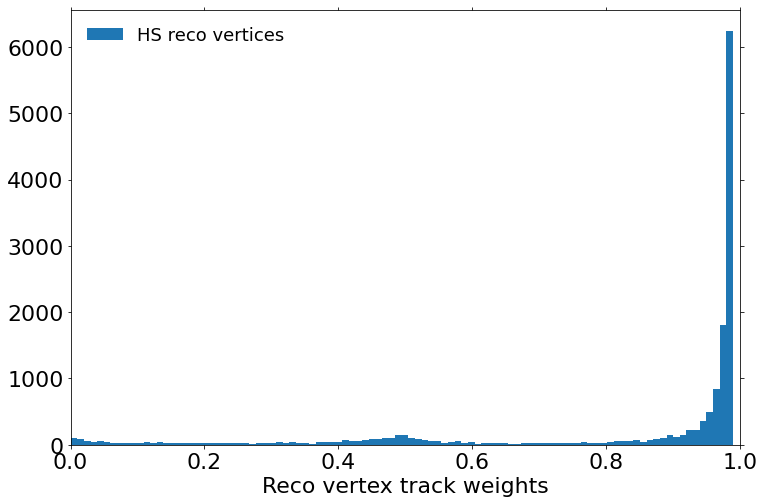

In [5]:
# _ = plt.hist(reco_vertex_track_weights_flat, bins=100, label='All reco vertices')
_ = plt.hist(reco_vertex_HS_track_weights_flat, bins=100, label='HS reco vertices')
# plt.yscale('log')
plt.xlim(0, 1)
plt.xlabel('Reco vertex track weights')
plt.legend(frameon=False)

In [6]:
delta_z = np.array([])
for event_idx in range(len(reco_vertex_track_idxs)):
    reco_z = reco_vertex_z[event_idx][0]
    truth_z = truth_vertex_z[event_idx][np.argmin(np.abs(reco_z-truth_vertex_z[event_idx]))]
    
    track_delta_zs = track_z0[event_idx][reco_vertex_track_idxs[event_idx][0]] - truth_z
    delta_z = np.concatenate((delta_z, track_delta_zs))
    
delta_t = np.array([])
for event_idx in range(len(reco_vertex_track_idxs)):
    reco_z = reco_vertex_z[event_idx][0]
    truth_t = truth_vertex_t[event_idx][np.argmin(np.abs(reco_z-truth_vertex_z[event_idx]))]
    
    track_delta_ts = track_t[event_idx][reco_vertex_track_idxs[event_idx][0]] - truth_t
    delta_t = np.concatenate((delta_t, track_delta_ts))

findfont: Font family ['Helvetica', 'Arial'] not found. Falling back to DejaVu Sans.


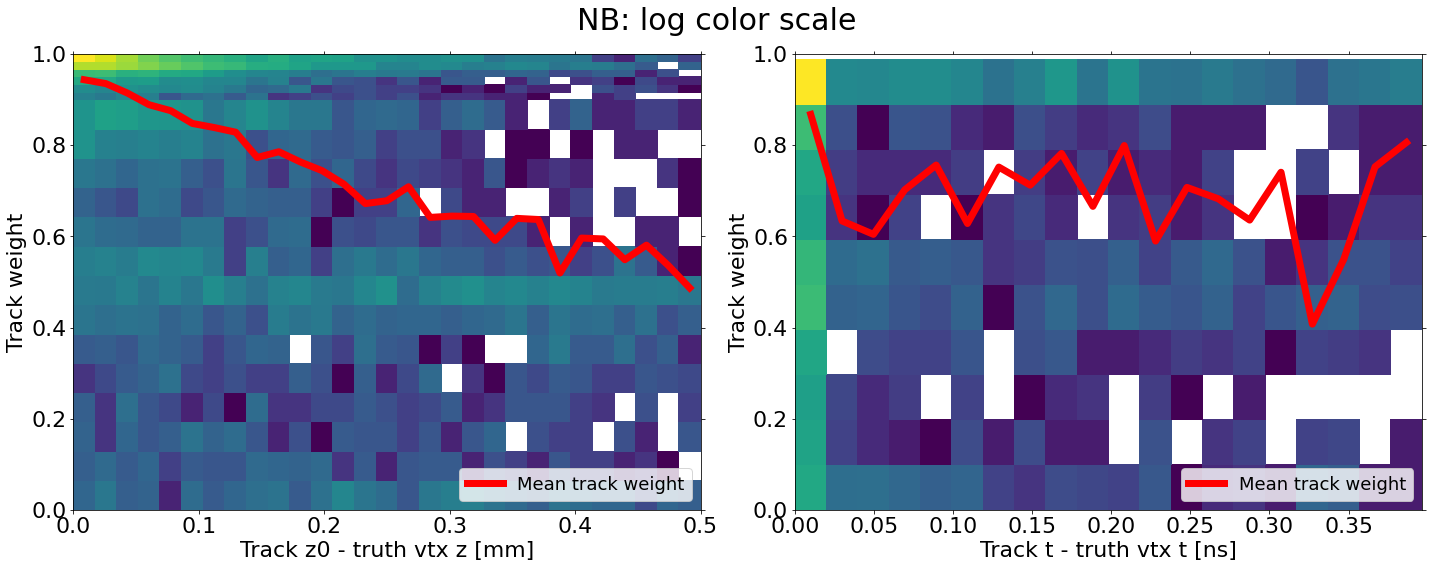

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(20, 8)

max_z = 0.5
idx1 = np.abs(delta_z) < max_z
xbins1 = np.linspace(0, max_z, 30)
ybins1 = np.concatenate((np.linspace(0, .90, 15), np.linspace(0.90, 1, 7)))

hist = ax1.hist2d(np.abs(delta_z[idx1]), reco_vertex_HS_track_weights_flat[idx1], bins=(xbins1, ybins1), norm = mpl.colors.LogNorm())
# hist = ax1.hist2d(np.abs(delta_z[idx1]), reco_vertex_HS_track_weights_flat[idx1], bins=(30, 50))
ax1.set_ylim(0, 1)
ax1.set_xlabel('Track z0 - truth vtx z [mm]')
ax1.set_ylabel('Track weight')

dz_bins = hist[1]
binned_mean_track_weight = binned_mean(np.abs(delta_z[idx1]), reco_vertex_HS_track_weights_flat[idx1], dz_bins)
ax1.plot(dz_bins[:-1]+(dz_bins[1]-dz_bins[0])/2, binned_mean_track_weight[0], 'r-', label='Mean track weight', lw=7)
ax1.legend(loc='lower right')

max_t = 0.4
idx2 = np.abs(delta_t) < max_t
xbins2 = 20
ybins2 = 10

hist2 = ax2.hist2d(np.abs(delta_t[idx2]), reco_vertex_HS_track_weights_flat[idx2], bins=(xbins2, ybins2), norm = mpl.colors.LogNorm())
# hist2 = ax2.hist2d(np.abs(delta_t[idx2]), reco_vertex_HS_track_weights_flat[idx2], bins=(30, 50))
ax2.set_ylim(0, 1)
ax2.set_xlabel('Track t - truth vtx t [ns]')
ax2.set_ylabel('Track weight')

dt_bins = hist2[1]
binned_mean_track_weight = binned_mean(np.abs(delta_t[idx2]), reco_vertex_HS_track_weights_flat[idx2], dt_bins)
ax2.plot(dt_bins[:-1]+(dt_bins[1]-dt_bins[0])/2, binned_mean_track_weight[0], 'r-', label='Mean track weight', lw=7)
ax2.legend(loc='lower right')

fig.suptitle('NB: log color scale', fontsize=30)
fig.tight_layout()

#Normalize both plots in the same way - or show z axis

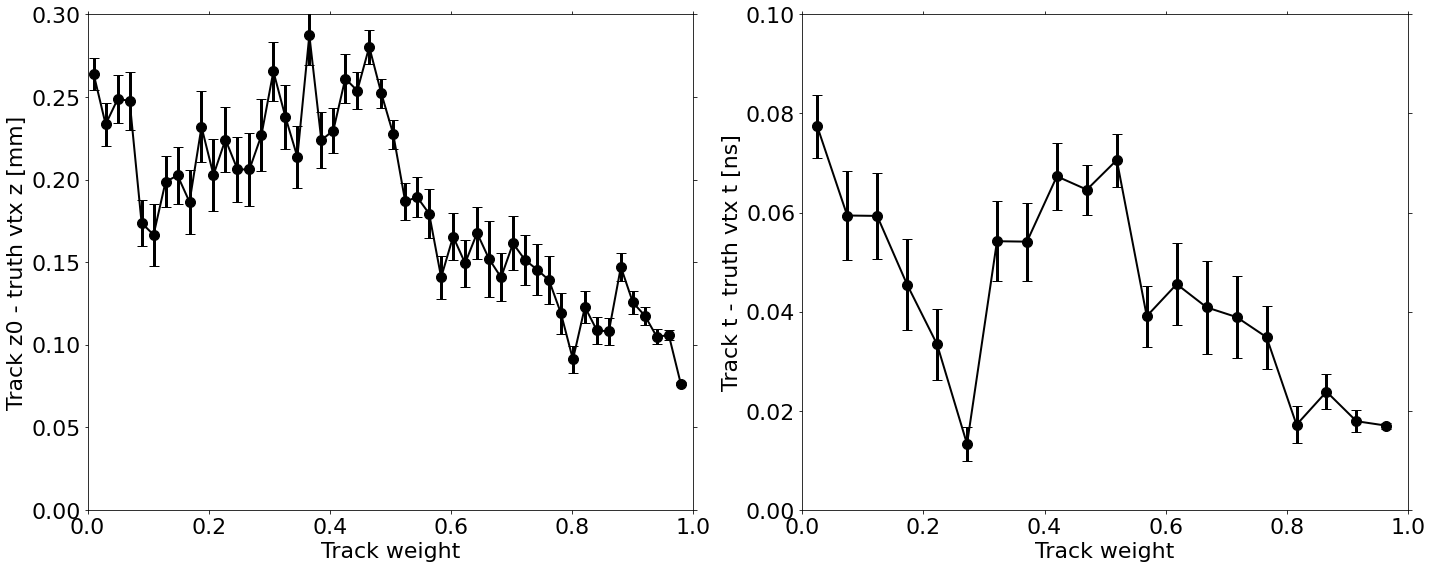

In [24]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(20, 8)

max_z = 0.5
idx1 = np.abs(delta_z) < max_z
xbins1 = 50
ybins1 = np.linspace(0, max_z, 30)

hist = np.histogram2d(reco_vertex_HS_track_weights_flat[idx1], np.abs(delta_z[idx1]), bins=(xbins1, ybins1))


bins = hist[1]
binned_mean_track_weight = binned_mean(reco_vertex_HS_track_weights_flat[idx1], np.abs(delta_z[idx1]), bins)
ax1.errorbar(bins[:-1]+(bins[1]-bins[0])/2, *binned_mean_track_weight, fmt='ko-',\
                 ms=10, lw=2, elinewidth=3, capsize=5)
ax1.set_xlim(0, 1)
ax1.set_ylim(0, 0.3)
ax1.set_xlabel('Track weight')
ax1.set_ylabel('Track z0 - truth vtx z [mm]')

max_t = 0.4
idx2 = np.abs(delta_t) < max_t
xbins2 = 20
ybins2 = 15

hist2 = np.histogram2d(reco_vertex_HS_track_weights_flat[idx2], np.abs(delta_t[idx2]), bins=(xbins2, ybins2))

bins2 = hist2[1]
binned_mean_track_weight = binned_mean(reco_vertex_HS_track_weights_flat[idx2], np.abs(delta_t[idx2]), bins2)
ax2.errorbar(bins2[:-1]+(bins2[1]-bins2[0])/2, *binned_mean_track_weight, fmt='ko-',\
                 ms=10, lw=2, elinewidth=3, capsize=5)
ax2.set_xlim(0, 1)
ax2.set_ylim(0, 0.1)
ax2.set_xlabel('Track weight')
ax2.set_ylabel('Track t - truth vtx t [ns]')


fig.tight_layout()

#Normalize both plots in the same way - or show z axis
# New plot:
# invert axis - only red line

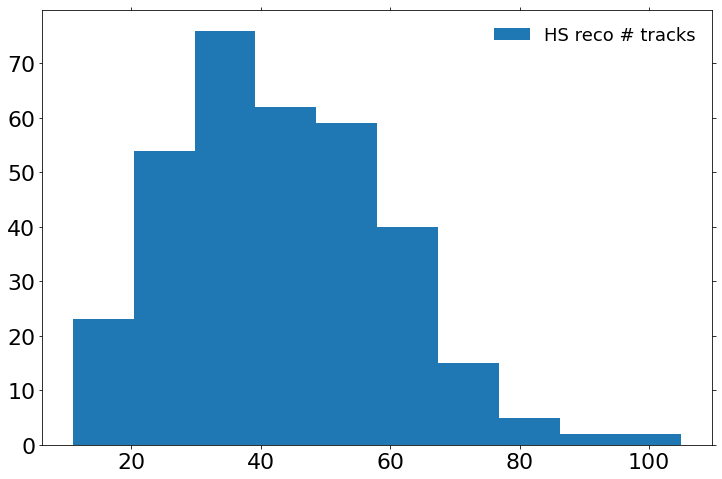

In [21]:
_ = plt.hist(reco_vertex_HS_n_tracks_flat, bins=10, label='HS reco # tracks')
plt.legend(frameon=False)

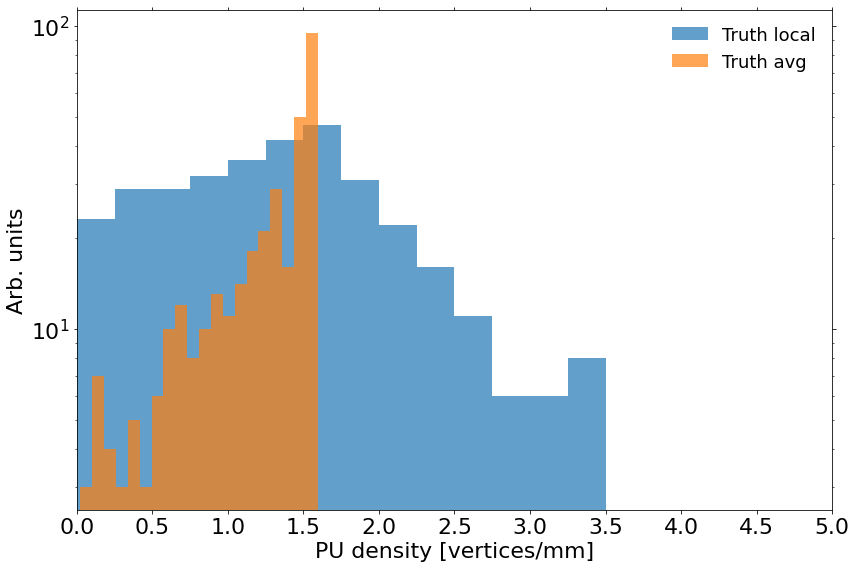

In [24]:
delta_z = 2
truth_localPU = computeLocalPUDensity(truth_vertex_z, delta_z)
reco_localPU = computeLocalPUDensity(reco_vertex_z,   delta_z)

truth_avgPU = computeAvgPUDensity(truth_vertex_z)
reco_avgPU = computeAvgPUDensity(reco_vertex_z)

binwidth = 1/(2*delta_z)

_, truth_bin_edges, _ = plt.hist(truth_localPU, bins=np.arange(np.min(truth_localPU), np.max(truth_localPU) + binwidth, binwidth), density=False, alpha=0.7, label='Truth local')
# _, reco_bin_edges, _  = plt.hist(reco_localPU,  bins=np.arange(np.min(reco_localPU), np.max(reco_localPU) + binwidth, binwidth), density=False, alpha=0.7, label='Reco local')

_, truth_avg_bin_edges, _ = plt.hist(truth_avgPU, bins=20, density=False, alpha=0.7, label='Truth avg')
# _, reco_avg_bin_edges, _  = plt.hist(reco_avgPU,  bins=np.arange(np.min(reco_localPU), np.max(reco_localPU) + binwidth, binwidth), density=False, alpha=0.7, label='Reco avg')

# plt.text(0.1, 1900, 'Local PU $\\Delta z = {}$ mm'.format(delta_z), fontsize=22)

plt.xlabel('PU density [vertices/mm]')
plt.ylabel('Arb. units')
plt.yscale('log')
plt.xticks(np.arange(0, 10, 0.5))
plt.xlim(0, 5)
plt.legend(frameon=False)
plt.tight_layout()